# Setup workflow environment

In [1]:
using Pkg; Pkg.activate(@__DIR__)

import TulipaIO as TIO
using DuckDB
using DataFrames
using Plots

# For Win. system to fix the KaTex parse error in Jupyter Notebook
Base.show(stdout, ::MIME"text/latex", df::DataFrame) = show(stdout, MIME("text/plain"), df)

#= For utility functions
    - print_annual_total_prod(DBconnection, years...)
    - inv_cost, fom_cost, var_cost = objective_terms_value(TulipaProblem, DBconnection)
    - annual_flows_between_assets(DB_conn, from_asset_term, to_asset_term)
=#
include("./util_analysis.jl");

  Activating project at `c:\ModellingRepos\VintageDemo`


- Rebuild DB connection of output and input data such that the plotting can be independent of model runs.
- Plotting code [reference](https://docs.juliaplots.org/dev/gallery/gr/generated/gr-ref056/)

In [2]:
!(@isdefined connection_no_vintage) && begin 
    connection_no_vintage = DBInterface.connect(DuckDB.DB) 
    TIO.read_csv_folder(connection_no_vintage, "model-instance-Tulipa/inputs-no-vintage")
    TIO.read_csv_folder(connection_no_vintage, "model-instance-Tulipa/outputs-no-vintage")
end

!(@isdefined connection_vintage_standard) && begin 
    connection_vintage_standard = DBInterface.connect(DuckDB.DB) 
    TIO.read_csv_folder(connection_vintage_standard, "model-instance-Tulipa/inputs-vintage-standard")
    TIO.read_csv_folder(connection_vintage_standard, "model-instance-Tulipa/outputs-vintage-standard")
end

!(@isdefined connection_vintage_compact) && begin 
    connection_vintage_compact = DBInterface.connect(DuckDB.DB) 
    TIO.read_csv_folder(connection_vintage_compact, "model-instance-Tulipa/inputs-vintage-compact")
    TIO.read_csv_folder(connection_vintage_compact, "model-instance-Tulipa/outputs-vintage-compact")
end;

## 1. Wind installation over years

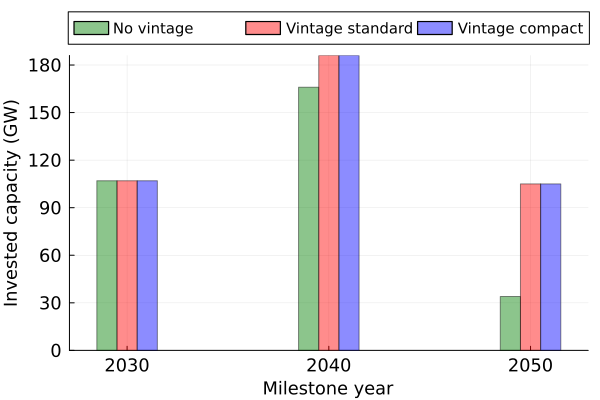

In [3]:
assets_investment_no_vintage = filter(row -> row.asset == "wind", TIO.get_table(connection_no_vintage, "var_assets_investment"))
assets_investment_vintage_standard = filter(row -> occursin("wind", row.asset), TIO.get_table(connection_vintage_standard, "var_assets_investment"))
assets_investment_vintage_compact = filter(row -> row.asset == "wind", TIO.get_table(connection_vintage_compact, "var_assets_investment"))

plot(
    (assets_investment_no_vintage.milestone_year .- 1), assets_investment_no_vintage.solution,
    label="No vintage",
    seriestype=:bar,
    bar_edge = :false,
    bar_width = 1,
    # markersize=7, markerstrokewidth=3,
    # markershape=:xcross,
    color=:green, alpha = 0.45,
    xlabel="Milestone year", xguidefontsize=12, 
    ylabel="Invested capacity (GW)", yguidefontsize=12,
    yticks = 0:30:210,
    xticks=minimum(assets_investment_no_vintage.milestone_year):10:maximum(assets_investment_no_vintage.milestone_year),
    xtickfontsize=12,ytickfontsize=12,
    legend=:outertop , legendfontsize=10,
    legend_column = -1
)
plot!(
    assets_investment_vintage_standard.milestone_year, assets_investment_vintage_standard.solution,
    label="Vintage standard",
    seriestype=:bar,
    bar_edge = :false,
    bar_width = 1,
    # markersize=7, markerstrokewidth=3,
    # markershape=:circle,
    color=:red, alpha = 0.45,
)
plot!(
    (assets_investment_vintage_compact.milestone_year .+ 1), assets_investment_vintage_compact.solution,
    label="Vintage compact",
    seriestype=:bar,
    bar_edge = :false,
    bar_width = 1,
    # markersize=9, markerstrokewidth=3
    # markershape=:cross,
    color=:blue, alpha = 0.45,
)

# savefig(joinpath(@__DIR__, "model-instance-Tulipa/result_plots", "wind_investment_capacity.pdf"));

## 2. Power generation over years

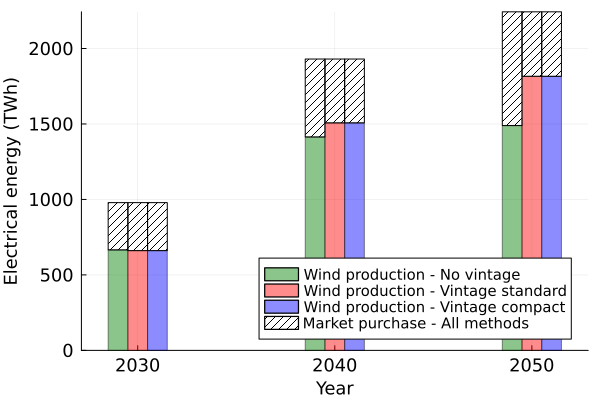

In [4]:
wind_to_demand_no_vintage = annual_flows_between_assets(connection_no_vintage, "wind", "demand")
wind_to_demand_vintage_standard = annual_flows_between_assets(connection_vintage_standard, "wind", "demand")
wind_to_demand_vintage_compact = annual_flows_between_assets(connection_vintage_compact, "wind", "demand")

ens_to_demand_no_vintage = annual_flows_between_assets(connection_no_vintage, "ens", "demand")
ens_to_demand_vintage_standard = annual_flows_between_assets(connection_vintage_standard, "ens", "demand")
ens_to_demand_vintage_compact = annual_flows_between_assets(connection_vintage_compact, "ens", "demand")

plot(
    (wind_to_demand_no_vintage.milestone_year .- 1), wind_to_demand_no_vintage.annual_flow,
    label="Wind production - No vintage",
    seriestype=:bar,
    bar_edge = :false,
    # bar_position = :overlay,
    bar_width = 1,
    color=:green, alpha = 0.45,
    yticks = 0:500:3000,
    xticks=minimum(wind_to_demand_no_vintage.milestone_year):10:maximum(wind_to_demand_no_vintage.milestone_year),
    xtickfontsize=12,ytickfontsize=12,
    xlabel="Year", xguidefontsize=12, 
    ylabel="Electrical energy (TWh)", yguidefontsize=12,
    legend=:bottomright, legendfontsize=10,
    legend_column = 1,
)
plot!(
    wind_to_demand_vintage_standard.milestone_year, wind_to_demand_vintage_standard.annual_flow,
    label="Wind production - Vintage standard",
    seriestype=:bar,
    bar_edge = :false,
    bar_width = 1,
    color=:red, alpha = 0.45,
)
plot!(
    (wind_to_demand_vintage_compact.milestone_year .+ 1), wind_to_demand_vintage_compact.annual_flow,
    label="Wind production - Vintage compact",
    seriestype=:bar,
    bar_edge = :false,
    bar_width = 1,
    color=:blue, alpha = 0.45,
)

plot!(
    (ens_to_demand_no_vintage.milestone_year .- 1), 
    ens_to_demand_no_vintage.annual_flow .+ wind_to_demand_no_vintage.annual_flow,
    fillto = wind_to_demand_no_vintage.annual_flow,
    label="Market purchase - All methods",
    seriestype=:bar,
    bar_edge = :false,
    bar_width = 1,
    color=:black, alpha = 1,
    fillstyle = :/,
)
plot!(
    ens_to_demand_vintage_standard.milestone_year, 
    ens_to_demand_vintage_standard.annual_flow .+ wind_to_demand_vintage_standard.annual_flow,
    fillto = wind_to_demand_vintage_standard.annual_flow,
    label="",
    seriestype=:bar,
    bar_edge = :false,
    bar_width = 1,
    color=:black, alpha = 1,
    fillstyle = :/,
)
plot!(
    (ens_to_demand_vintage_compact.milestone_year .+ 1), 
    ens_to_demand_vintage_compact.annual_flow .+ wind_to_demand_vintage_compact.annual_flow,
    fillto = wind_to_demand_vintage_compact.annual_flow,
    label="",
    seriestype=:bar,
    bar_edge = :false,
    bar_width = 1,
    color=:black, alpha = 1,
    fillstyle = :/,
)

# savefig(joinpath(@__DIR__, "model-instance-Tulipa/result_plots", "annual_productions.pdf"));